# Задание 3. Ансамбли алгоритмов. Композиции алгоритмов для решения задачи регрессии
# Автор: Листопадов Иван

Подключение модулей:

In [1]:
import numpy as np
import pandas as pd

from ensembles import RandomForestMSE, GradientBoostingMSE

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plt
from time import time

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn-whitegrid')

Загрузка данных, разделение на обучающую и тестовую выборку

In [14]:
data = pd.read_csv('kc_house_data.csv')
target = data['price']
data = data.drop('price', axis=1)

In [15]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Преобразуем столбец с датой в формат ГГГГММДД и добавим по нему на 3 новых признака: год (`'year'`), месяц (`'month'`) и день (`'day'`).

In [16]:
data['date'] = data['date'].apply(lambda x: x[:8])

In [17]:
data["year"] = data["date"].apply(lambda x: int(x[:4]))
data["month"] = data["date"].apply(lambda x: int(x[4:6]))
data["day"] = data["date"].apply(lambda x: int(x[6:]))
data = data.drop("date", axis=1)

In [18]:
data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,2009,0,98144,47.5944,-122.299,1020,2007,2014,6,23
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,...,2004,0,98027,47.5345,-122.069,1410,1287,2015,1,16


In [19]:
X_train, X_test, y_train, y_test = [np.array(array) for array in train_test_split(data,
                                                                                  target, test_size=0.3, random_state=241,
                                                                                  shuffle=True)]

Из множества признаков исключена цена жилья ('price'), так как колонка с ней содержит значения целевой переменной (target).

Функция для тестирования моделей:

In [20]:
def test(model_type, n_estimators, feature_subsample_size=1.0, max_depth=None, learning_rate=1.0):
    if model_type == 'rf':
        model = RandomForestMSE(
            n_estimators=n_estimators,
            feature_subsample_size=feature_subsample_size,
            max_depth=max_depth
        )
    elif model_type == 'gb':
        model = GradientBoostingMSE(
            n_estimators=n_estimators,
            feature_subsample_size=feature_subsample_size,
            max_depth=max_depth,
            learning_rate=learning_rate
        )
    model.fit(X_train, y_train)
    return np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

## RandomForestMSE

Начнём с RandomForestMSE. Для начала поймём, как взаимосвязано количество деревьев, используемых в алгоритме, с временем обучения этих деревьев и получаемым качеством.

In [21]:
n_est_list = 10 * np.arange(1, 20)
score_list = []
time_list = []
for n_est in n_est_list:
    start_time = time()
    score_list.append(test('rf', n_estimators=n_est))
    time_list.append(time() - start_time)

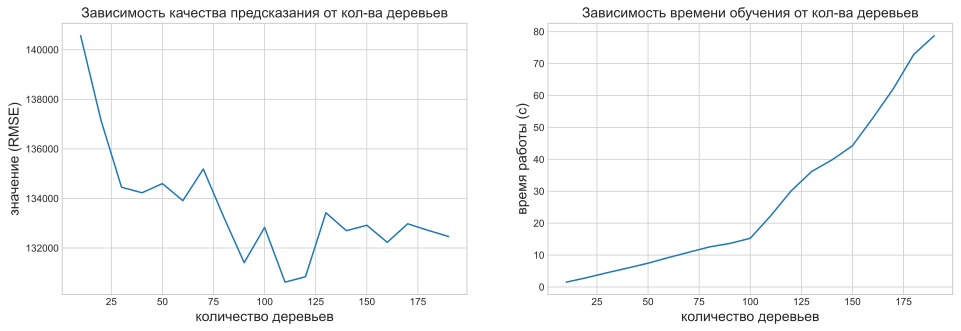

In [22]:
fg, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.set_title('Зависимость качества предсказания от кол-ва деревьев', fontsize=14)
ax1.set_xlabel('количество деревьев', fontsize=14)
ax1.set_ylabel('значение (RMSE)', fontsize=14)
ax1.plot(n_est_list, score_list)

ax2.set_title('Зависимость времени обучения от кол-ва деревьев', fontsize=14)
ax2.set_xlabel('количество деревьев', fontsize=14)
ax2.set_ylabel('время работы (с)', fontsize=14)
ax2.plot(n_est_list, time_list)
fg.savefig("1.1.pdf",bbox_inches = 'tight')

plt.show()

С увеличением количества деревьев увеличивается качество предсказания, но и увеличивается общее время работы. В этом опыте глубина деревьев не ограничивалась и могла влиять на зависимости. Чтобы это проверить построим такие же графики, но с добавленным ограничением.

In [23]:
max_depth_list = [1, 5, 10, None]
n_est_list = 10 * np.arange(1, 20, 4)
score_matrix = np.zeros((len(max_depth_list), len(n_est_list)))
time_matrix = np.zeros((len(max_depth_list), len(n_est_list)))

for i, max_depth in enumerate(max_depth_list):
    for j, n_est in enumerate(n_est_list):
        start_time = time()
        score_matrix[i, j] = test('rf', n_estimators=n_est, max_depth=max_depth)
        time_matrix[i, j] = time() - start_time

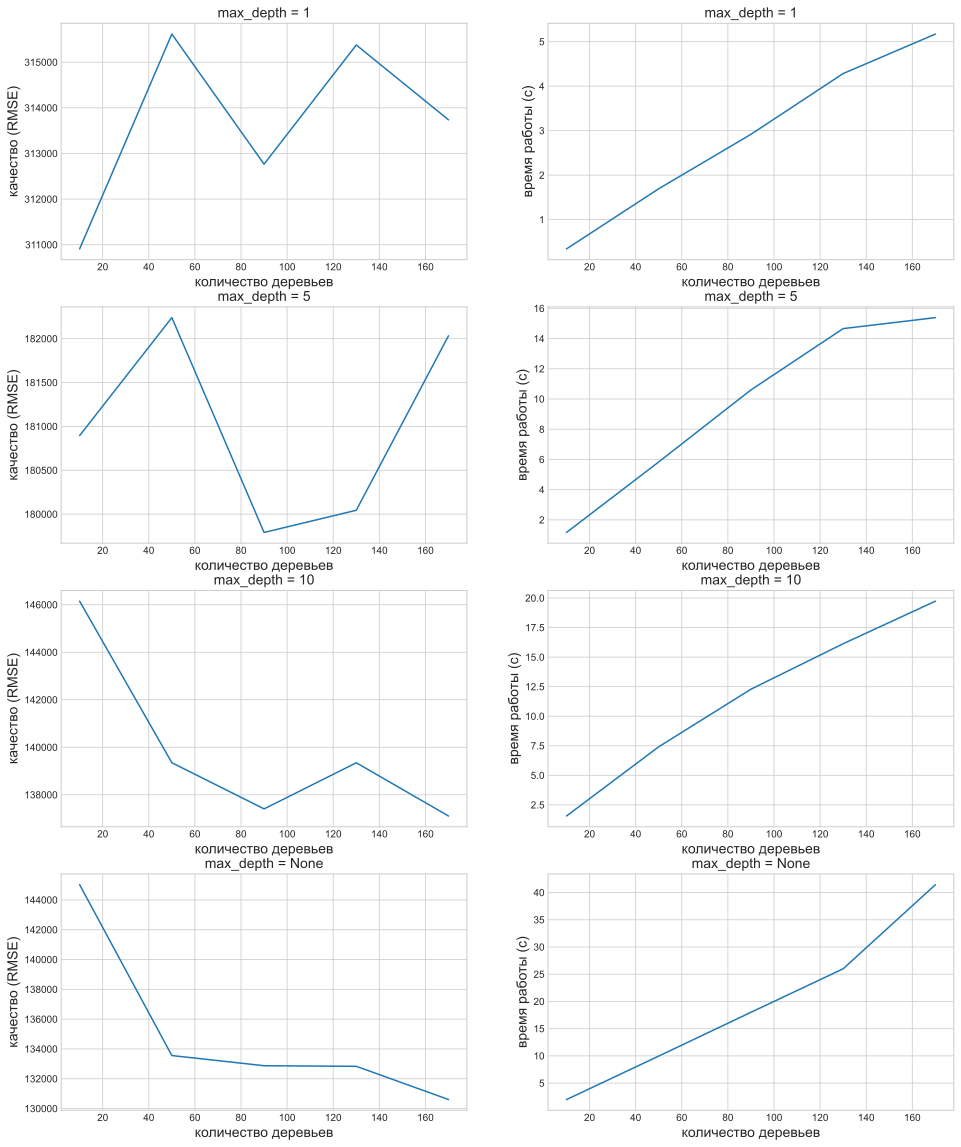

In [30]:
fg, ax = plt.subplots(4, 2, figsize=(16, 20))

for i in range(4):
    ax[i][0].set_xlabel('количество деревьев', fontsize=14)
    ax[i][1].set_xlabel('количество деревьев', fontsize=14)
    ax[i][0].set_ylabel('качество (RMSE)', fontsize=14)
    ax[i][1].set_ylabel('время работы (с)', fontsize=14)
    ax[i][0].set_title('max_depth = ' + str(max_depth_list[i]), fontsize=14)
    ax[i][1].set_title('max_depth = ' + str(max_depth_list[i]), fontsize=14)


ax[0][0].plot(n_est_list, score_matrix[0])
ax[0][1].plot(n_est_list, time_matrix[0])
ax[1][0].plot(n_est_list, score_matrix[1])
ax[1][1].plot(n_est_list, time_matrix[1])
ax[2][0].plot(n_est_list, score_matrix[2])
ax[2][1].plot(n_est_list, time_matrix[2])
ax[3][0].plot(n_est_list, score_matrix[3])
ax[3][1].plot(n_est_list, time_matrix[3])

fg.savefig("1.2.pdf",bbox_inches = 'tight')

plt.show()

Глубина деревьев значительно влияет на время обучения модели. Заметим, что после определенного порога количества деревьев в модели
качество перестаёт расти или растёт очень медленно.

Прослеживается тенденция, что при увеличении глубины деревье качество модели повышается. Проверим это на больших значениях глубин деревьев, выбирая в качестве оптимального значения колчиества деревьев `n_estimators`=90.

In [37]:
max_depth_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
score_depth = []
time_list = []

for max_depth in max_depth_list:
    start_time = time()
    score_depth.append(test('rf', n_estimators=90, max_depth=max_depth))
    time_list.append(time() - start_time)

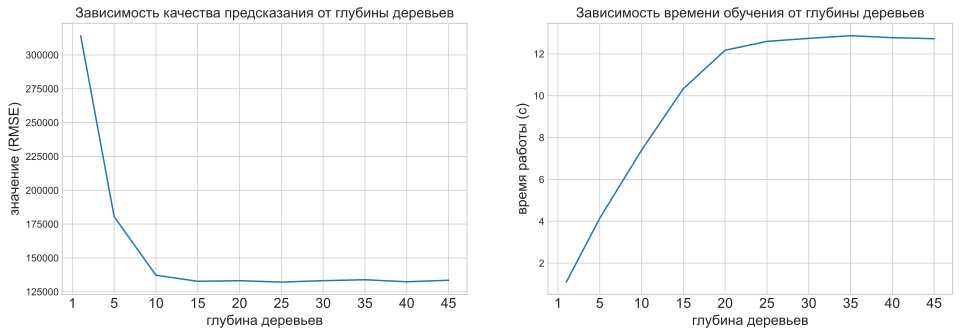

In [61]:
fg, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.set_title('Зависимость качества предсказания от глубины деревьев', fontsize=14)
ax1.set_xlabel('глубина деревьев', fontsize=14)
ax1.set_ylabel('значение (RMSE)', fontsize=14)
ax1.set_xticks(np.arange(0,50,5))
ax1.set_xticklabels(list(map(str, max_depth_list[:-1])), fontsize=14)
ax1.plot(max_depth_list, score_depth)

ax2.set_title('Зависимость времени обучения от глубины деревьев', fontsize=14)
ax2.set_xlabel('глубина деревьев', fontsize=14)
ax2.set_ylabel('время работы (с)', fontsize=14)
ax2.set_xticks(np.arange(0, 50, 5))
ax2.set_xticklabels(list(map(str, max_depth_list[:-1])), fontsize=14)
ax2.plot(max_depth_list, time_list)
fg.savefig("1.2.2.pdf",bbox_inches = 'tight')

plt.show()

Как видно из графика, более глубокие деревья будут давать лучшую точность на тестовой выборке. Время обучения зависит линейно только при глубине деревьев <= 15. Поэтому в качестве оптимальной глубины будем исползовать неограниченную глубину.

Все деревья до этого момента обучались на одних и тех же признаках. В общей схеме возможен факт появления идентичных деревьев. Чтобы уменьшить вероятность такого события, каждое дерево будем обучать на подмножестве множества всех признаков, размер которого мы будем варьировать.

In [31]:
feat_list = np.linspace(0.1, 1.0, 10)
score_list = []
for feat_size in feat_list:
    score_list.append(test('rf', n_estimators=50, feature_subsample_size=feat_size, max_depth=10))

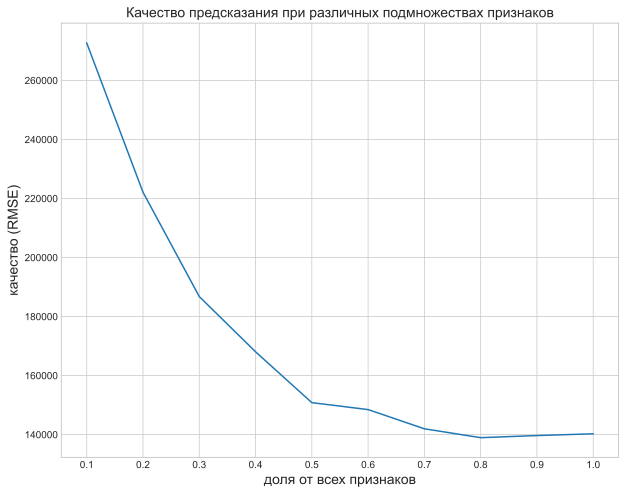

In [64]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

plt.title('Качество предсказания при различных подмножествах признаков', fontsize=14)
plt.xlabel('доля от всех признаков', fontsize=14)
ax.set_xticks(np.linspace(0.1, 1.0, 10))
plt.ylabel('качество (RMSE)', fontsize=14)
plt.plot(feat_list, score_list)
fig.savefig("1.3.pdf",bbox_inches = 'tight')

plt.show()

С ростом числа признаков время работы алгоритма растёт линейно, поэтому оптимальным можно считать количество признаков равное 21*0.8 = 16.8 ~ 16.

Построим итоговую модель с найденными параметрами:

In [65]:
model = RandomForestMSE(n_estimators=90, max_depth=None, feature_subsample_size=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 134555.02084802647


# GradientBoostingMSE

Теперь перейдём к градиентному бустингу над решающими деревьями.

Установим качество и время работы алгоритма при различном количестве деревьев, участвующих в предсказании.

In [115]:
n_est_list = 10 * np.arange(1, 20)
score_list = []
time_list = []
for n_est in n_est_list:
    start_time = time()
    score_list.append(test('gb', n_estimators=n_est))
    time_list.append(time() - start_time)

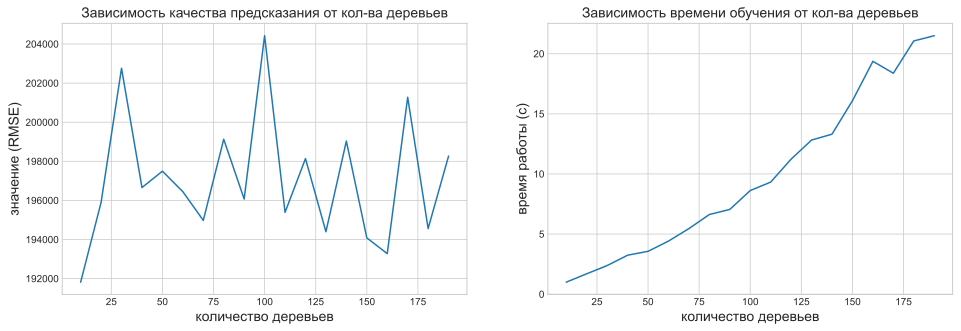

In [117]:
fg, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.set_title('Зависимость качества предсказания от кол-ва деревьев', fontsize=14)
ax1.set_xlabel('количество деревьев', fontsize=14)
ax1.set_ylabel('значение (RMSE)', fontsize=14)
ax1.plot(n_est_list, score_list)

ax2.set_title('Зависимость времени обучения от кол-ва деревьев', fontsize=14)
ax2.set_xlabel('количество деревьев', fontsize=14)
ax2.set_ylabel('время работы (с)', fontsize=14)
ax2.plot(n_est_list, time_list)

plt.show()

fg.savefig("2.1.pdf",bbox_inches = 'tight')

Время работы градиентного бустинга меньше, но качество начинает колебаться при увеличении количества деревьев. Посмотрим, что будет с качеством при меньшем числе дереьев (от 1 до 30).

In [118]:
n_est_list = np.arange(1, 30)
score_list = []
for n_est in n_est_list:
    score_list.append(test('gb', n_estimators=n_est))

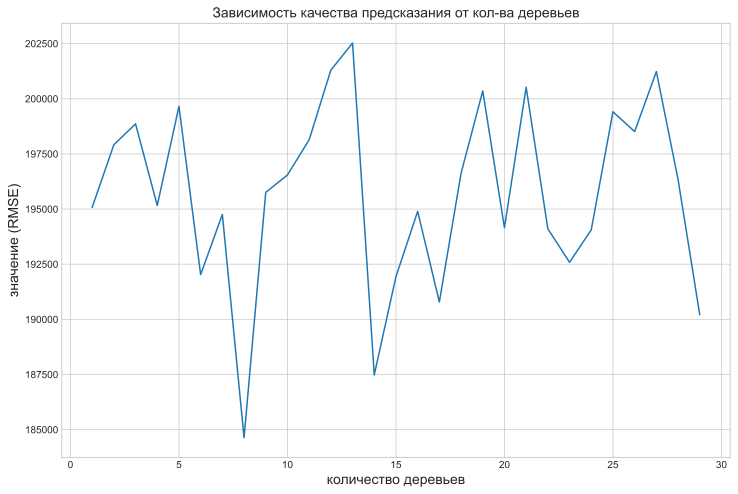

In [120]:
fig = plt.figure(figsize=(12, 8))
plt.title('Зависимость качества предсказания от кол-ва деревьев', fontsize=14)
plt.xlabel('количество деревьев', fontsize=14)
plt.ylabel('значение (RMSE)', fontsize=14)
plt.plot(n_est_list, score_list)

plt.show()
fig.savefig("2.1.1.pdf",bbox_inches = 'tight')

Среднее значение качества очень медлено убывает до определённого порога, затем возрастаёт и начинает колебаться. На результат может повлиять тот факт, что глубина каждого отдельного дерева ничем не ограничивается. Повторим эксперимент, введя различные ограничения на глубину.

In [121]:
max_depth_list = [1, 5, 10, None]
n_est_list = np.arange(10, 100, 10)
score_matrix = np.zeros((len(max_depth_list), len(n_est_list)))
time_matrix = np.zeros((len(max_depth_list), len(n_est_list)))

for i, max_depth in enumerate(max_depth_list):
    for j, n_est in enumerate(n_est_list):
        start_time = time()
        score_matrix[i, j] = test('gb', n_estimators=n_est, max_depth=max_depth)
        time_matrix[i, j] = time() - start_time

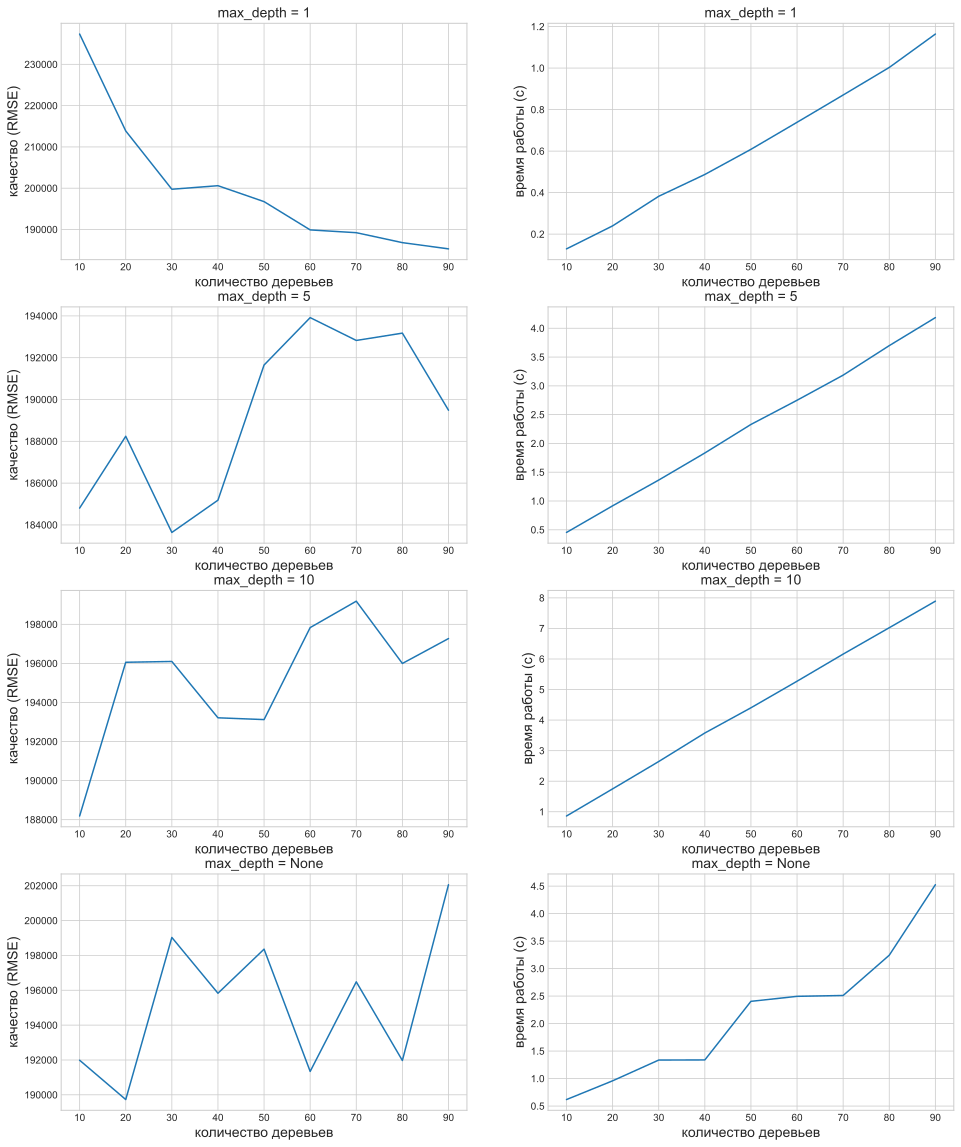

In [122]:
fg, ax = plt.subplots(4, 2, figsize=(16, 20))

for i in range(4):
    ax[i][0].set_xlabel('количество деревьев', fontsize=14)
    ax[i][1].set_xlabel('количество деревьев', fontsize=14)
    ax[i][0].set_ylabel('качество (RMSE)', fontsize=14)
    ax[i][1].set_ylabel('время работы (с)', fontsize=14)
    ax[i][0].set_title('max_depth = ' + str(max_depth_list[i]), fontsize=14)
    ax[i][1].set_title('max_depth = ' + str(max_depth_list[i]), fontsize=14)

ax[0][0].plot(n_est_list, score_matrix[0])
ax[0][1].plot(n_est_list, time_matrix[0])
ax[1][0].plot(n_est_list, score_matrix[1])
ax[1][1].plot(n_est_list, time_matrix[1])
ax[2][0].plot(n_est_list, score_matrix[2])
ax[2][1].plot(n_est_list, time_matrix[2])
ax[3][0].plot(n_est_list, score_matrix[3])
ax[3][1].plot(n_est_list, time_matrix[3])

plt.show()
fg.savefig("2.2.pdf",bbox_inches = 'tight')

Лучшие показатели достигаются на ограничении по глубине деревьев: `5` и количестве деревьев: `20`. Всё сходится к тому, что для лучшего результата нужно маленькое количество деревьев с достаточно небольшой глубиной. Проверим, можно ли на это повлиять путём вариации количества признаков, на которых обучаются деревья.

In [123]:
feat_list = np.linspace(0.1, 1.0, 10)
score_list = []
for feat_size in feat_list:
    score_list.append(test('gb', n_estimators=20, feature_subsample_size=feat_size, max_depth=10))

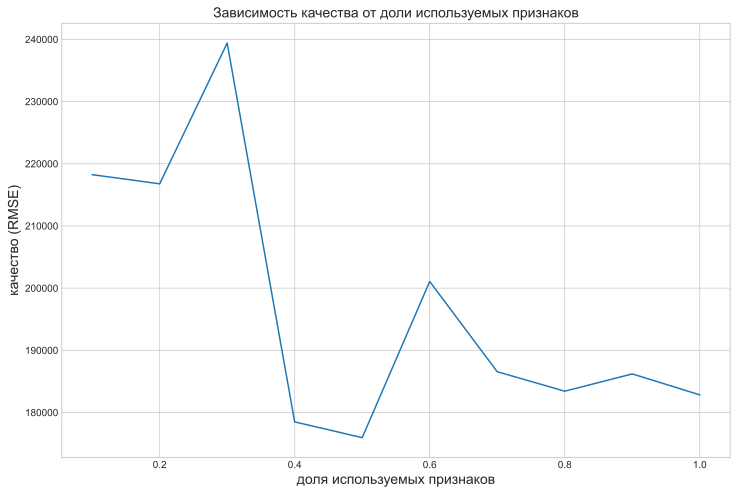

In [124]:
fig = plt.figure(figsize=(12, 8))
plt.title('Зависимость качества от доли используемых признаков', fontsize=14)
plt.xlabel('доля используемых признаков', fontsize=14)
plt.ylabel('качество (RMSE)', fontsize=14)
plt.plot(feat_list, score_list)
plt.show()
fig.savefig("2.3.pdf",bbox_inches = 'tight')

Качество заметно повышается при использовании только некоторой части признаков, однако, так как это часть задаётся случайно, тяжело предугадать изменение качества. Есть вероятность того, что в выборке присутствуют заведомо "плохие" признаки, которые портят общий результат, и их попадание в подмножество признаков для каждого дерева влияет сильно на качество. В этом случае при равных параметрах могут выдаваться разные результаты.

Последний параметр, который будем варьировать - `learning rate`, посмотрим на его влияние на работу алгоритма.

In [125]:
learning_rate_list = np.linspace(0.1, 2.0, 20)
score_list = []
for l_rate in learning_rate_list:
    score_list.append(test('gb', n_estimators=10, learning_rate=l_rate, max_depth=5))

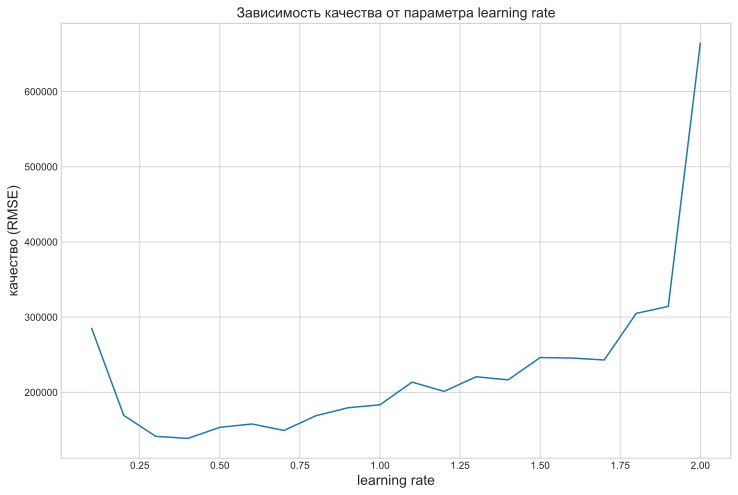

In [126]:
fig = plt.figure(figsize=(12, 8))
plt.title('Зависимость качества от параметра learning rate', fontsize=14)
plt.xlabel('learning rate', fontsize=14)
plt.ylabel('качество (RMSE)', fontsize=14)
plt.plot(learning_rate_list, score_list)
plt.show()
fig.savefig("2.4.pdf",bbox_inches = 'tight')

Наилучшее значение для данной модели `learning_rate = ~ 0.4`, то есть, когда параметр `learning_rate` уменьшает влияние каждого дерева более, чем в 2 раза.

Построим итоговую модель с лучшими параметрами:

In [127]:
model = GradientBoostingMSE(n_estimators=20, learning_rate=0.4, feature_subsample_size=1.0, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 130931.11131716342


### Вывод:
В ходе работы были реализованы алгоритмы предсказания RandomForest и GradientBoosting на решающих деревьях. Алгоритм случайного леса выдавал ожидаемые результаты: при увеличении количества деревьев росло качество и время работы, но не бесконечно. С очень большим количеством деревьев затрачиваемое время работы становится слишком большим и появляется риск переобучения. Имеет смысл проводить тонкую настройку деревьев, например, регулировать их максимальную глубину, признаковое пространство, на котором они обучаются, чтобы получить результат более высокого уровня с точки зрения качества и времени работы. Метод градиентного бустинга над решающими деревьями на протяжении всех экспериментов выдавал неоднозначные результаты. Увеличение размера ансамбля слабо влияло на качество, в некоторых местах даже ухудшало, исходя из экпериментов, можно вообще сделать вывод, что, чем меньше деревьев задействованы в работе, тем лучше. В случае всего лишь одного дерева метод вырождается в одно решающее дерево, причём и глубину брать маленькую также выгоднее, чем большую. А это равносильно тому, что мы осуществляем предсказание для объекта, основываясь лишь на значении одного признака: больше оно или  меньше определенного порога для этого признака. В этих случаях регулирование остальных параметров не имеет большого смысла. Все эти выкладки подтверждаются работой оригинальной реализации метода градиентного бустинга на решающих деревьях из модуля `sklearn.ensemble`. Несмотря на все замечания второй метод работает чуть лучше первого. И возникает вопрос: не лучше ли использовать одно тонко настроенное дерево? Теоретически нет, не лучше. Проблема может заключаться в отсутствии предобработки входных данных. Никак не были исследованы признаки, их полезность и влияние на работу методов. Также были проигнорированы возможные объекты-выбросы, которые могут плохо влиять на предсказательную способность алгоритмов.